In [27]:
import scipy
from imageio import imread
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import cytoolz as cz
import tensorflow as tf
import idx2numpy
import functools
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import random
from dataget import data 

%matplotlib inline

In [28]:
dataset = data("german-traffic-signs").get()

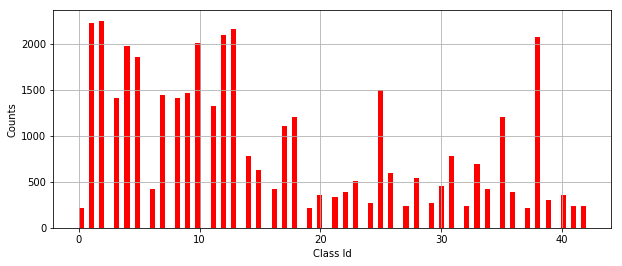

Dataset size:  39209


In [3]:
df = dataset.training_set.dataframe()
# df = df.sample(frac=1)

plt.figure(figsize=(10,4))
df.class_id.hist(bins=100, color='r')
plt.xlabel('Class Id')
plt.ylabel('Counts')
plt.show()
print('Dataset size: ', len(df.class_id))

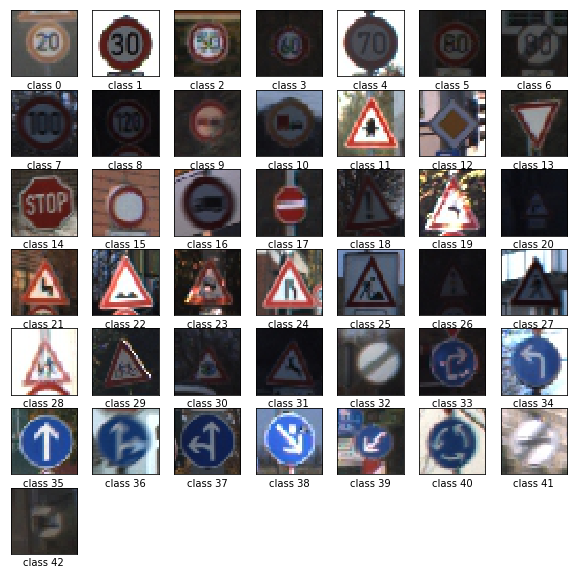

In [4]:
fig=plt.figure(figsize=(10, 10))
rows = 7
cols = 7

for i in range(1, 44):
    img = df.image[df['class_id']==i-1]
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img[int(np.random.choice(range(len(img)), 1))])
    ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')   
    ax.set_xlabel('class {}'.format(i-1))
plt.show()

In [5]:
#data Augmentation

def flip_verticaly(image):
    return np.flipud(image)

def flip_horizontally(image):
    return np.fliplr(image)
    
def flip_both(image):
    image = flip_horizontally(image)
    return flip_verticaly(image)


def flip_images_augmentation(df, num_class):

    
    appended_data = []
    
    flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    flippable_vertically = np.array([1, 5, 12, 15, 17])
    flippable_both = np.array([32, 40])
    cross_class_id = np.array([[19, 20], [33, 34], 
                        [36, 37], [38, 39], 
                        [20, 19], [34, 33], 
                        [37, 36], [39, 38]])
    
    for c in range(43):
        
        if c in flippable_vertically:
#             print('flippable_vertically {}'.format(c))
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_verticaly)
            appended_data.append(new_df)
            
        if c in flippable_horizontally:
#             print('flippable_horizontally {}'.format(c))
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_horizontally)
            appended_data.append(new_df)
            
        elif c in flippable_both:
#             print('flippable_both {}'.format(c))
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_both)
            appended_data.append(new_df)
            
        elif c in cross_class_id[:, 0]:
#             print('cross_class_id {}'.format(c))
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_horizontally)
            new_df.loc[row_indexer, 'class_id'] = new_df[row_indexer].class_id.apply(lambda x: cross_class_id[cross_class_id[:, 0] == x][0][1])
            appended_data.append(new_df)

    appended_data = pd.concat(appended_data, axis=0) 
    return pd.concat([df, appended_data])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


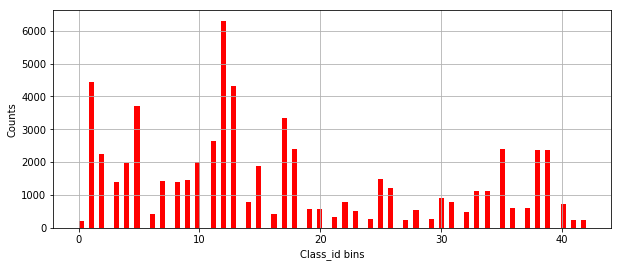

Current Dataset Size:  63538


In [25]:
augmented = flip_images_augmentation(df, 43)

plt.figure(figsize=(10, 4))
augmented.class_id.hist(bins=100, color='r')
plt.xlabel('Class_id bins')
plt.ylabel('Counts')
plt.show()
print("Current Dataset Size: ", len(augmented))

In [26]:
augmented.head(5)

,filename,width,height,roi.x1,roi.y1,roi.x2,roi.y2,class_id,image,is_flipped
0,/home/ubuntu/.dataget/data/german-traffic-sign...,29,30,5,6,24,25,0,"[[[73, 78, 82], [77, 76, 72], [92, 85, 75], [1...",False
1,/home/ubuntu/.dataget/data/german-traffic-sign...,30,30,5,5,25,25,0,"[[[72, 72, 72], [75, 80, 74], [71, 78, 71], [7...",False
2,/home/ubuntu/.dataget/data/german-traffic-sign...,30,30,5,5,25,25,0,"[[[73, 72, 70], [79, 80, 75], [81, 77, 68], [1...",False
3,/home/ubuntu/.dataget/data/german-traffic-sign...,31,31,5,5,26,26,0,"[[[68, 67, 65], [73, 72, 78], [92, 79, 89], [1...",False
4,/home/ubuntu/.dataget/data/german-traffic-sign...,30,32,5,6,25,26,0,"[[[72, 73, 78], [73, 74, 78], [79, 71, 69], [1...",False


In [8]:
# rotation
def rotate_image(img, theta=18):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    new_img = cv2.warpAffine(new_img,M,(cols,rows))
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# scaling
def scale_image(img, x_scale=0.85, y_scale=1.15) :
    r, c = img.shape[:-1]
    scaled_img = cv2.resize(img,None,fx=x_scale,fy=y_scale)
    new_img = cv2.copyMakeBorder(scaled_img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# translation
def translate_image(img, delta_x=2, delta_y=-2):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2)+delta_y, round((cols-c)/2)-delta_x
    return new_img[r0:r0+r, c0:c0+c]

In [9]:
def random_transform(img) :
    new_img = img
    transform_list = [rotate_image, translate_image, scale_image]
    random.shuffle(transform_list)
    for transform in transform_list :
        new_img = transform(new_img)
    return new_img

In [10]:
def perturb_data(df, n):
    
    feature = []
    num_classes = 43
    
    for label in range(num_classes):
        
        n_fake = n-len(df[df['class_id']==label])
        if n_fake <= 0 : continue
        
        for j in range(n_fake):
            num = np.random.choice(len(df[df['class_id']==label]), replace=False, size=1)
            im = df[df['class_id']==label].image.iloc[int(num)]
            filename = df[df['class_id']==label].filename.iloc[int(num)]
            feature.append({'filename': filename, 'class_id': label, 'image': random_transform(im)})
            
    return pd.DataFrame(feature)

In [11]:
X_train_pert = perturb_data(augmented, 5000)

In [29]:
df_train = pd.concat([X_train_pert, augmented])
df_train = df_train.sample(frac=1).reset_index()
df_train.head(5)

,index,class_id,filename,height,image,is_flipped,roi.x1,roi.x2,roi.y1,roi.y2,width
0,108983,31,/home/ubuntu/.dataget/data/german-traffic-sign...,NaN,"[[[31, 28, 22], [31, 28, 22], [31, 28, 22], [3...",NaN,NaN,NaN,NaN,NaN,NaN
1,565,14,/home/ubuntu/.dataget/data/german-traffic-sign...,119.0,"[[[255, 255, 202], [192, 180, 128], [145, 141,...",False,10.0,106.0,11.0,109.0,116.0
2,125401,36,/home/ubuntu/.dataget/data/german-traffic-sign...,NaN,"[[[41, 47, 43], [41, 47, 43], [41, 47, 43], [4...",NaN,NaN,NaN,NaN,NaN,NaN
3,247,21,/home/ubuntu/.dataget/data/german-traffic-sign...,46.0,"[[[45, 47, 44], [41, 40, 36], [50, 42, 39], [5...",False,6.0,48.0,5.0,41.0,53.0
4,76037,24,/home/ubuntu/.dataget/data/german-traffic-sign...,NaN,"[[[56, 48, 43], [54, 48, 45], [56, 47, 43], [6...",NaN,NaN,NaN,NaN,NaN,NaN


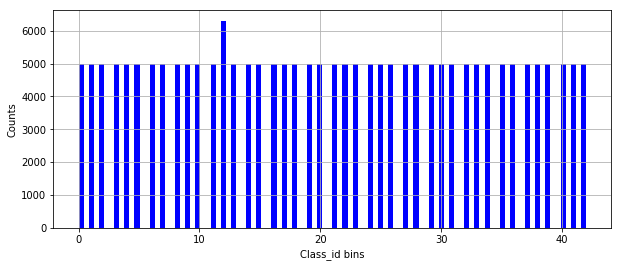

Current Dataset Size:  216300


In [23]:
plt.figure(figsize=(10, 4))
df_train.class_id.hist(bins=100, color='b')
plt.xlabel('Class_id bins')
plt.ylabel('Counts')
plt.show()
print("Current Dataset Size: ", len(df_train))

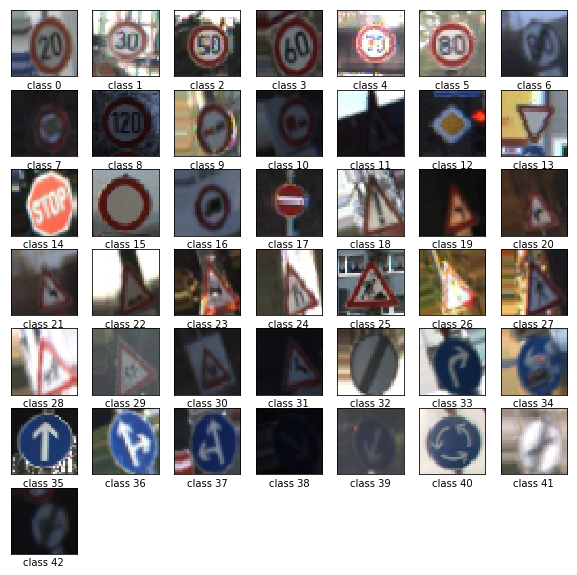

In [30]:
fig=plt.figure(figsize=(10, 10))
rows = 7
cols = 7

for i in range(1, 44):
    img = df_train.index[df_train['class_id']==i-1]
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(df_train.image.iloc[int(np.random.choice(img, 1))])
    ax.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')   
    ax.set_xlabel('class {}'.format(i-1))
plt.show()

In [16]:
# Training Parameters
learning_rate = 0.001
num_steps = 0
batch_size = 64
epochs = 50

# Network Parameters
num_classes = 43 
dropout = 0.25 # Dropout, probability to dnput_fn = tf.estimator.inputs.numpy_inpurop a unit

In [17]:
# Neural Network
def conv_net(features, labels, mode):
    
    print()
    print("#######################")
    print("Model")
    print("#######################")
    
    input_layer = tf.reshape(features["image"], [-1, 32, 32, 3]);print(input_layer)

    conv1 = tf.layers.conv2d(input_layer, 32, 5, activation=tf.nn.relu); print(conv1)
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same'); print(pool1)

    conv2 = tf.layers.conv2d(pool1, 64, 5, activation=tf.nn.relu); print(conv2)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same'); print(pool2)
    
    conv3 = tf.layers.conv2d(pool2, 128, 5, activation=tf.nn.relu); print(conv3)
    pool3 = tf.layers.max_pooling2d(conv3, 2, 2, padding='same'); print(pool3)

    # Flatten the data to a 1-D vector for the fully connected layer
    pool2_flat = tf.contrib.layers.flatten(pool3); print(pool2_flat)

    #fully connected layer
    dense = tf.layers.dense(pool2_flat, 1024, activation=tf.nn.relu); print(dense)

    #dropout
    fc1 = tf.layers.dropout(dense, rate=dropout, training=mode == tf.estimator.ModeKeys.TRAIN); print(fc1)
    logits = tf.layers.dense(fc1, units=num_classes); print(logits)
    print("#######################")
    print()


    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=num_classes)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [18]:
model = tf.estimator.Estimator(model_fn=conv_net, 
        model_dir="/tmp/german")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/german', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1cd584bfd0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
from skimage import exposure
def reshape_image(img, width, height):
    return cv2.resize(img, (width, height))

def rgb2gray(image):

    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    image = (image / 255.).astype(np.float32)

    return image

def process(df, epochs=5, steps=0, batch_size=batch_size):
    
    if epochs:
        steps = int(len(df)/batch_size)*epochs
        
    for _ in range(steps):
        data_set = df.sample(n=batch_size)
        
        images = list(cz.map(lambda x: x, data_set.image))
#         images = list(cz.map(lambda d: rgb2gray(d), images))
        image = np.array([i for i in images])
        labels = data_set['class_id'].values
        yield image, labels
          
def input_fn(df):
    dataset = tf.data.Dataset.from_generator(
        functools.partial(process, df=df),
        (tf.float32, tf.float32),
        (tf.TensorShape([batch_size, 32, 32, 3]), tf.TensorShape([batch_size]))
    )
    features, labels = dataset.make_one_shot_iterator().get_next()
    return {'image': features}, labels

In [20]:
# Train the Model
model.train(input_fn=functools.partial(input_fn, df=df_train))


#######################
Model
#######################
Tensor("Reshape:0", shape=(64, 32, 32, 3), dtype=float32)
Tensor("conv2d/Relu:0", shape=(64, 28, 28, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(64, 14, 14, 32), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(64, 10, 10, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("conv2d_3/Relu:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(64, 128), dtype=float32)
Tensor("dense/Relu:0", shape=(64, 1024), dtype=float32)
Tensor("dropout/dropout/mul:0", shape=(64, 1024), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(64, 43), dtype=float32)
#######################

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/german/model.ckpt.
INFO:tensorflow:loss = 17.1001, step = 1
INFO:tensorflow:global_step/sec: 58.7385
INFO:t

INFO:tensorflow:loss = 0.423413, step = 7501 (1.660 sec)
INFO:tensorflow:global_step/sec: 60.3475
INFO:tensorflow:loss = 0.244588, step = 7601 (1.658 sec)
INFO:tensorflow:global_step/sec: 59.8738
INFO:tensorflow:loss = 0.0787851, step = 7701 (1.669 sec)
INFO:tensorflow:global_step/sec: 59.5358
INFO:tensorflow:loss = 0.0628298, step = 7801 (1.679 sec)
INFO:tensorflow:global_step/sec: 59.1819
INFO:tensorflow:loss = 0.0631542, step = 7901 (1.690 sec)
INFO:tensorflow:global_step/sec: 60.0433
INFO:tensorflow:loss = 0.406871, step = 8001 (1.667 sec)
INFO:tensorflow:global_step/sec: 59.7454
INFO:tensorflow:loss = 0.00535579, step = 8101 (1.673 sec)
INFO:tensorflow:global_step/sec: 59.9563
INFO:tensorflow:loss = 0.223513, step = 8201 (1.667 sec)
INFO:tensorflow:global_step/sec: 60.0099
INFO:tensorflow:loss = 0.109622, step = 8301 (1.668 sec)
INFO:tensorflow:global_step/sec: 59.3668
INFO:tensorflow:loss = 0.148204, step = 8401 (1.684 sec)
INFO:tensorflow:global_step/sec: 59.4881
INFO:tensorflow

INFO:tensorflow:loss = 0.101792, step = 15801 (1.712 sec)
INFO:tensorflow:global_step/sec: 58.9719
INFO:tensorflow:loss = 6.40694e-06, step = 15901 (1.694 sec)
INFO:tensorflow:global_step/sec: 58.8666
INFO:tensorflow:loss = 0.233758, step = 16001 (1.700 sec)
INFO:tensorflow:global_step/sec: 59.1794
INFO:tensorflow:loss = 0.0462485, step = 16101 (1.690 sec)
INFO:tensorflow:global_step/sec: 59.5283
INFO:tensorflow:loss = 0.122782, step = 16201 (1.680 sec)
INFO:tensorflow:global_step/sec: 58.926
INFO:tensorflow:loss = 0.0305482, step = 16301 (1.696 sec)
INFO:tensorflow:global_step/sec: 59.0481
INFO:tensorflow:loss = 0.285652, step = 16401 (1.694 sec)
INFO:tensorflow:global_step/sec: 58.4994
INFO:tensorflow:loss = 0.133862, step = 16501 (1.711 sec)
INFO:tensorflow:global_step/sec: 59.6631
INFO:tensorflow:loss = 0.174753, step = 16601 (1.674 sec)
INFO:tensorflow:global_step/sec: 59.6019
INFO:tensorflow:loss = 0.163291, step = 16701 (1.678 sec)
INFO:tensorflow:global_step/sec: 58.7841
INFO:t

In [21]:
# Evaluate the Model
model.evaluate(input_fn=functools.partial(input_fn, df=dataset.test_set.dataframe()))


#######################
Model
#######################
Tensor("Reshape:0", shape=(64, 32, 32, 3), dtype=float32)
Tensor("conv2d/Relu:0", shape=(64, 28, 28, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(64, 14, 14, 32), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(64, 10, 10, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("conv2d_3/Relu:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(64, 128), dtype=float32)
Tensor("dense/Relu:0", shape=(64, 1024), dtype=float32)
Tensor("dropout/Identity:0", shape=(64, 1024), dtype=float32)
Tensor("dense_2/BiasAdd:0", shape=(64, 43), dtype=float32)
#######################

INFO:tensorflow:Starting evaluation at 2018-01-25-01:11:25
INFO:tensorflow:Restoring parameters from /tmp/german/model.ckpt-16895
INFO:tensorflow:Finished evaluation at 2018-01-25-01:11:29
INFO:tensorflow:

{'accuracy': 0.9100095, 'global_step': 16895, 'loss': 0.59789437}